In [1]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, BFGS
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_moons

In [6]:
n_samples = 50
C_const = 100
threshold = 1e-3

In [42]:
def linear_kernel(x, z):
    return  np.dot(x.T,z)

In [43]:
def polynomial_kernel(x, z):
    return pow((np.dot(x.T,z) +1),3)

In [44]:
def function_to_optimize(alphas, y, x, kernel):
    func_opt= sum(alphas)
    m= len(x)
    for i in range(m):
        for j in range(m):
            func_opt= func_opt - 0.5* alphas[i]*alphas[j]*y[i]*y[j]*kernel(x[i], x[j])
    return -func_opt

In [45]:
def find_support_vector_inds(alphas, thresh):
    return [i for i in range(len(alphas)) if alphas[i]>thresh]

In [46]:
def find_w_b(alphas, y, x, sv_inds, kernel, thresh, C):
    if kernel.__name__=='polynomial_kernel':
        w=None
    else:
        w=0
        for i in range(len(x)):
            w= w + alphas[i]* y[i]*x[i]     

    j=sv_inds[0]
    b=y[j]
    for i in sv_inds:    
        b= b- alphas[i]*y[i]*kernel(x[i],x[j])         
    return w, b

In [24]:
def predict(alphas, y, x, x_test, b, sv_inds, kernel):
    predictions = np.zeros(shape=(len(x_test),))
    
    for i in range(len(predictions)):
        predictions[i]=b
        for j in sv_inds:    
            predictions[i]= predictions[i] + alphas[j]*y[j]*kernel(x_test[i],x[j]) 
    predictions[predictions<0]=-1
    predictions[predictions>0]=+1 
    return predictions

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [4.86351569e+00 3.49300737e-02 1.39324072e-03 1.26188112e-03
 9.99966187e+01 1.45702544e-03 2.23481049e-03 1.91525051e-03
 3.83165680e+01 1.64990810e-03 1.34427689e-03 9.99984796e+01
 1.66033694e-02 2.84637159e-03 1.07587228e-03 1.27984649e-03
 1.95935458e-03 3.40315336e-03 1.12740280e-03 1.23877866e-02
 3.08526216e-01 3.31153505e+01 2.30941084e-03]


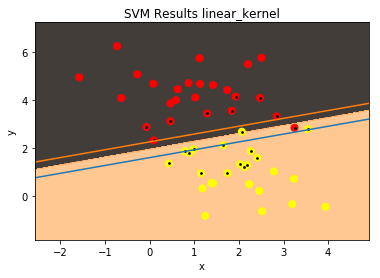

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [0.65051092 0.25179738 1.20534076 0.80662596]


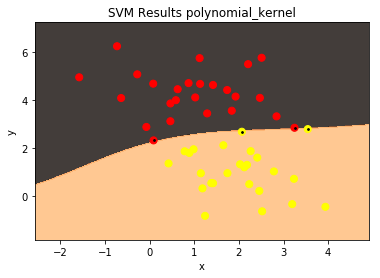

In [47]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, BFGS
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_moons


# this is the main function which brings it all together
# examine it to understand what's happening in each line
# you only need to finish two lines of code here, describing the constraints
# don't change anything else (!)
def minimize_and_plot(X, Y, kernel, C, thresh):
    n = len(Y)
    # arguments to pass to minimize function
    args = (Y, X, kernel)

    # define the constraints (page 20) as instances of scipy.optimize.LinearConstraint
    # constraints each alpha to be from 0 to C
    alpha_constr = LinearConstraint(np.identity(n), 0, C)  # todo write your code here (one-liner)
    # constraints sum of (alpha * y)
    alpha_y_constr = LinearConstraint(Y, 0, 0)  # todo write your code here (one-liner)

    print("Starting computations...")
    # minimization. we are using ready QP solver 'trust-constr'
    result = minimize(fun=function_to_optimize, method='trust-constr', x0=np.empty(shape=(n,)), jac='2-point',
                      hess=BFGS(exception_strategy='skip_update'), constraints=[alpha_constr, alpha_y_constr],
                      args=args)
    # prints the results. If status==0, then the optimizer failed to find the optimal value
    print("status:", result.status)
    print("message:", result.message)

    alphas = result.x
    # indexes of support vectors
    sv_inds = find_support_vector_inds(alphas, thresh)
    print("alphas of support vectors:", '\n', alphas[sv_inds])

    w, b = find_w_b(alphas, Y, X, sv_inds, kernel, thresh, C)

    # create a mesh to plot points and predictions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xrange, yrange = np.meshgrid(np.arange(x_min, x_max, 0.02),
                                 np.arange(y_min, y_max, 0.02))
    # form a grid by taking each point point from x and y range
    grid = np.c_[xrange.ravel(), yrange.ravel()]
    grid = grid.astype(float)
    # make predictions for each point of the grid
    grid_predictions = predict(alphas, Y, X, grid, b, sv_inds, kernel)
    grid_predictions = grid_predictions.reshape(xrange.shape)

    # plot color grid points according to the prediction made for each point
    plt.contourf(xrange, yrange, grid_predictions, cmap='copper', alpha=0.8)
    # plot initial data points
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
    # plot support vectors
    plt.scatter(X[sv_inds, 0], X[sv_inds, 1], s=3, c="black")

    if w is not None:  # print lines on which support vectors should reside
        x_plot = np.linspace(x_min, x_max - 0.02, 1000)
        y_plot_1 = (- w[0] * x_plot - b + 1) / w[1]
        y_plot_2 = (- w[0] * x_plot - b - 1) / w[1]
        plt.plot(x_plot, y_plot_1)
        plt.plot(x_plot, y_plot_2)

    plt.title('SVM Results ' + kernel.__name__)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    
# here we assign values for constants
# you can change them when you are testing your solution but when submitting leave it in the original state
n_samples = 50
C_const = 100
threshold = 1e-3

# generating (almost) linearly separable data, replacing 0 labels with -1
X_blob, Y_blob = make_blobs(n_samples=n_samples, centers=2, random_state=0, cluster_std=1.00)
Y_blob[Y_blob == 0] = -1
#plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, s=50, cmap='autumn')
#plt.show()
minimize_and_plot(X_blob, Y_blob, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_blob, Y_blob, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel

# generating moon-shaped data, replacing 0 labels with -1
#X_moon, Y_moon = make_moons(n_samples=n_samples, shuffle=False, noise=0.10, random_state=0)
# plt.scatter(X_moon[:, 0], X_moon[:, 1], c=Y_moon, s=50, cmap='autumn')
# plt.show()
#minimize_and_plot(X_moon, Y_moon, linear_kernel, C_const, threshold)  # svm with linear kernel
#minimize_and_plot(X_moon, Y_moon, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel


Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [4.20207552 2.01190865 2.52741224 6.16825007 1.94321953 0.62992586]


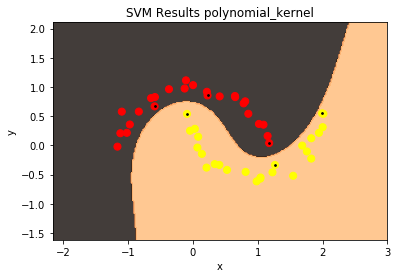

In [49]:
# generating moon-shaped data, replacing 0 labels with -1
X_moon, Y_moon = make_moons(n_samples=n_samples, shuffle=False, noise=0.10, random_state=0)
Y_moon[Y_moon == 0] = -1
# plt.scatter(X_moon[:, 0], X_moon[:, 1], c=Y_moon, s=50, cmap='autumn')
# plt.show()
#minimize_and_plot(X_moon, Y_moon, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_moon, Y_moon, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel
